In [2]:
#import necessary packages
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

In [7]:
#import Data
PL19_20_fixtures = pd.read_csv('Data/2019-20/Fixtures/PL19_20_fixtures.csv')
PL20_21_fixtures = pd.read_csv('Data/2020-21/Fixtures/PL20_21_fixtures.csv')
PL21_22_fixtures = pd.read_csv('Data/2021-22/Fixtures/PL21_22_fixtures.csv')
#PL20_21_fixtures.replace(['Manchester Utd', 'Tottenham'], ['Manchester United','Tottenham Hotspur'], inplace=True)
PL19_20_fixtures['game_home_ID'] = PL19_20_fixtures['HomeTeam'] + PL19_20_fixtures['Date'].astype(str)
PL19_20_fixtures['game_away_ID'] = PL19_20_fixtures['AwayTeam'] + PL19_20_fixtures['Date'].astype(str)
PL20_21_fixtures['game_home_ID'] = PL20_21_fixtures['HomeTeam'] + PL20_21_fixtures['Date'].astype(str)
PL20_21_fixtures['game_away_ID'] = PL20_21_fixtures['AwayTeam'] + PL20_21_fixtures['Date'].astype(str)
PL21_22_fixtures['game_home_ID'] = PL21_22_fixtures['HomeTeam'] + PL21_22_fixtures['Date'].astype(str)
PL21_22_fixtures['game_away_ID'] = PL21_22_fixtures['AwayTeam'] + PL21_22_fixtures['Date'].astype(str)
PL21_22_fixtures

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,Rating_Home,Rating_Away,Rating difference,game_home_ID,game_away_ID
0,E0,2021-08-13,20:00,Brentford,Arsenal,2,0,H,1,0,...,2.13,2.05,2.17,1.80,2.09,73,79,-6,Brentford2021-08-13,Arsenal2021-08-13
1,E0,2021-08-14,12:30,Manchester Utd,Leeds United,5,1,H,1,0,...,1.77,2.19,1.93,2.10,1.79,83,76,7,Manchester Utd2021-08-14,Leeds United2021-08-14
2,E0,2021-08-14,15:00,Burnley,Brighton,1,2,A,1,0,...,2.14,1.82,2.19,1.79,2.12,76,75,1,Burnley2021-08-14,Brighton2021-08-14
3,E0,2021-08-14,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,1.81,2.16,1.93,2.06,1.82,83,76,7,Chelsea2021-08-14,Crystal Palace2021-08-14
4,E0,2021-08-14,15:00,Everton,Southampton,3,1,H,0,1,...,1.88,2.08,1.90,2.03,1.86,79,76,3,Everton2021-08-14,Southampton2021-08-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,2022-05-22,16:00,Crystal Palace,Manchester Utd,1,0,H,1,0,...,2.23,1.88,2.25,1.74,2.16,76,83,-7,Crystal Palace2022-05-22,Manchester Utd2022-05-22
376,E0,2022-05-22,16:00,Leicester City,Southampton,4,1,H,0,0,...,2.03,1.94,2.26,1.87,2.01,80,76,4,Leicester City2022-05-22,Southampton2022-05-22
377,E0,2022-05-22,16:00,Liverpool,Wolves,3,1,H,1,1,...,1.83,2.19,1.99,2.07,1.80,84,78,6,Liverpool2022-05-22,Wolves2022-05-22
378,E0,2022-05-22,16:00,Manchester City,Aston Villa,3,2,H,0,1,...,1.86,2.09,2.03,2.01,1.87,85,78,7,Manchester City2022-05-22,Aston Villa2022-05-22


In [8]:
#generate gameweeks dependening on the order of the games
def generate_gameweeks(df):
    teams = df.HomeTeam.unique().tolist()
    df['Wk_h'] = 0
    df['Wk_a'] = 0
    for team in teams:
        count = 1
        for index, row in df.iterrows():
            if row['HomeTeam'] == team:
                df.at[index, 'Wk_h'] = count
                count = count + 1
            elif row['AwayTeam'] == team:
                df.at[index, 'Wk_a'] = count
                count = count + 1
    return df

PL19_20_fixtures = generate_gameweeks(PL19_20_fixtures)
PL20_21_fixtures = generate_gameweeks(PL20_21_fixtures)
PL21_22_fixtures = generate_gameweeks(PL21_22_fixtures)

PL21_22_fixtures

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,MaxCAHA,AvgCAHH,AvgCAHA,Rating_Home,Rating_Away,Rating difference,game_home_ID,game_away_ID,Wk_h,Wk_a
0,E0,2021-08-13,20:00,Brentford,Arsenal,2,0,H,1,0,...,2.17,1.80,2.09,73,79,-6,Brentford2021-08-13,Arsenal2021-08-13,1,1
1,E0,2021-08-14,12:30,Manchester Utd,Leeds United,5,1,H,1,0,...,1.93,2.10,1.79,83,76,7,Manchester Utd2021-08-14,Leeds United2021-08-14,1,1
2,E0,2021-08-14,15:00,Burnley,Brighton,1,2,A,1,0,...,2.19,1.79,2.12,76,75,1,Burnley2021-08-14,Brighton2021-08-14,1,1
3,E0,2021-08-14,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,1.93,2.06,1.82,83,76,7,Chelsea2021-08-14,Crystal Palace2021-08-14,1,1
4,E0,2021-08-14,15:00,Everton,Southampton,3,1,H,0,1,...,1.90,2.03,1.86,79,76,3,Everton2021-08-14,Southampton2021-08-14,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,2022-05-22,16:00,Crystal Palace,Manchester Utd,1,0,H,1,0,...,2.25,1.74,2.16,76,83,-7,Crystal Palace2022-05-22,Manchester Utd2022-05-22,38,38
376,E0,2022-05-22,16:00,Leicester City,Southampton,4,1,H,0,0,...,2.26,1.87,2.01,80,76,4,Leicester City2022-05-22,Southampton2022-05-22,38,38
377,E0,2022-05-22,16:00,Liverpool,Wolves,3,1,H,1,1,...,1.99,2.07,1.80,84,78,6,Liverpool2022-05-22,Wolves2022-05-22,38,38
378,E0,2022-05-22,16:00,Manchester City,Aston Villa,3,2,H,0,1,...,2.03,2.01,1.87,85,78,7,Manchester City2022-05-22,Aston Villa2022-05-22,38,38


In [43]:
#functions for feature Engineering
def get_points(team, wk, df):
    #print(df.type)
    for index, row in df.iterrows():
        #print(row[['HomeTeam','Wk']])
        if row['Wk_h'] == wk and row['HomeTeam'] == team:
            if row['FTR'] == 'H':
                return 3
            if row['FTR'] == 'D':
                return 1
            else:
                return 0
        if row['Wk_a'] == wk and row['AwayTeam'] == team:
            if row['FTR'] == 'A':
                return 3
            if row['FTR'] == 'D':
                return 1
            else:
                return 0


def get_stats(team, wk, stat, df):
    for index, row in df.iterrows():
        #print(row[['HomeTeam','Wk']])
        if row['Wk_h'] == wk and row['HomeTeam'] == team:
            if stat == 'goals':
                return row['FTHG']
            elif stat == 'shots':
                return row['HST']
            elif stat == 'corners':
                return row['HC']
        elif row['Wk_a'] == wk and row['AwayTeam'] == team:
            if stat == 'goals':
                return row['FTAG']
            elif stat == 'shots':
                return row['AST']
            elif stat == 'corners':
                return row['AC']
            return row[stat]


def get_points_season(team, fr, to, df):
    test = []
    out = 0
    df2 = 0
    if fr == to: return 0
    for i in range(fr, to):
        out = out + get_points(team, i, df)
        test.append(out)
        df3 = pd.Series(test)
        df2 = df3.rolling(len(df3)).mean()
        df2 = df2[len(df3) - 1]
        #print(df2[len(df)-1])
        #print(df2)
    return df2


def get_stats_season(team, fr, to, category, df):
    test = []
    out = 0
    df2 = 0
    if fr == to: return 0
    for i in range(fr, to):
        out = out + get_stats(team, i, category, df)
        test.append(out)
        df3 = pd.Series(test)
        df2 = df3.rolling(len(df3)).mean()
        df2 = df2[len(df3) - 1]
        #df2 = df.ewm(alpha=0.4).mean()[len(df) - 1]
    return df2


def get_ewm_season(team, fr, to, df):
    test = []
    out = 0
    if fr == to: return 0
    for i in range(fr, to):
        out = out + get_points(team, i, df)
        test.append(out)
        df3 = pd.Series(test)
        df2 = df3.ewm(alpha=0.9).mean()[len(df3) - 1]
    return df2


def append_form(timespan, df):
    formH = []
    formA = []
    for index, row in df.iterrows():
        wk_h = row['Wk_h']
        wk_a = row['Wk_a']
        teamH = row['HomeTeam']
        teamA = row['AwayTeam']
        if int(wk_h) - timespan < 1:
            pointsH = get_points_season(teamH, 1, int(wk_h) - 1, df)
        else:
            pointsH = get_points_season(teamH, int(wk_h) - timespan, int(wk_h) - 1, df=df)
        if int(wk_a) - timespan < 1:
            pointsA = get_points_season(teamA, 1, int(wk_a) - 1, df)
        else:
            pointsA = get_points_season(teamA, int(wk_a) - timespan, int(wk_a) - 1, df=df)
        formH.append(pointsH)
        formA.append(pointsA)
    df['formH'] = formH
    df['formA'] = formA
    return df


def append_ewm(timespan, df):
    formH = []
    formA = []
    for index, row in df.iterrows():
        wk_h = row['Wk_h']
        wk_a = row['Wk_a']
        teamH = row['HomeTeam']
        teamA = row['AwayTeam']
        if int(wk_h) - timespan < 1:
            pointsH = get_ewm_season(teamH, 1, int(wk_h), df)
        else:
            pointsH = get_ewm_season(teamH, int(wk_h) - timespan, int(wk_h) - 1, df)
        if int(wk_a) - timespan < 1:
            pointsA = get_ewm_season(teamA, 1, int(wk_a), df)
        else:
            pointsA = get_ewm_season(teamA, int(wk_a) - timespan, int(wk_a) - 1, df)
        formH.append(pointsH)
        formA.append(pointsA)
    df['ewmH'] = formH
    df['ewmA'] = formA
    return df


def append_stats(timespan, df):
    goals_h = []
    goals_A = []
    shots_H = []
    shots_A = []
    corners_H = []
    corners_A = []

    for index, row in df.iterrows():
        wk_h = row['Wk_h']
        wk_a = row['Wk_a']
        teamH = row['HomeTeam']
        teamA = row['AwayTeam']
        if int(wk_h) - timespan < 1:
            goalsH = get_stats_season(teamH, 1, int(wk_h) - 1, 'goals', df)
            shotsH = get_stats_season(teamH, 1, int(wk_h) - 1, 'shots', df)
            cornersH = get_stats_season(teamH, 1, int(wk_h) - 1, 'corners', df)
        else:
            goalsH = get_stats_season(teamH, int(wk_h) - timespan, int(wk_h) - 1, 'goals', df)
            shotsH = get_stats_season(teamH, int(wk_h) - timespan, int(wk_h) - 1, 'shots', df)
            cornersH = get_stats_season(teamH, int(wk_h) - timespan, int(wk_h) - 1, 'corners', df)

        if int(wk_a) - timespan < 1:
            goalsA = get_stats_season(teamA, 1, int(wk_a) - 1, 'goals', df)
            shotsA = get_stats_season(teamA, 1, int(wk_a) - 1, 'shots', df)
            cornersA = get_stats_season(teamA, 1, int(wk_a) - 1, 'corners', df)
        else:
            goalsA = get_stats_season(teamA, int(wk_a) - timespan, int(wk_a) - 1, 'goals', df)
            shotsA = get_stats_season(teamA, int(wk_a) - timespan, int(wk_a) - 1, 'shots', df)
            cornersA = get_stats_season(teamA, int(wk_a) - timespan, int(wk_a) - 1, 'corners', df)

        goals_h.append(goalsH)
        goals_A.append(goalsA)
        shots_H.append(shotsH)
        shots_A.append(shotsA)
        corners_H.append(cornersH)
        corners_A.append(cornersA)
    df['goalsH'] = goals_h
    df['goalsA'] = goals_A
    df['shotsH'] = shots_H
    df['shotsA'] = shots_A
    df['cornersH'] = corners_H
    df['cornersA'] = corners_A
    return df


#Elo Rating
def expected_result(loc, aw):
    dr = loc - aw
    we = (1 / (10 ** (-dr / 400) + 1))
    return [np.round(we, 3), 1 - np.round(we, 3)]


def actual_result(loc, aw):
    if loc < aw:
        wa = 1
        wl = 0
    elif loc > aw:
        wa = 0
        wl = 1
    elif loc == aw:
        wa = 0.5
        wl = 0.5
    return [wl, wa]


def calculate_elo(elo_l, elo_v, local_goals, away_goals, k_value):
    k = k_value
    wl, wv = actual_result(local_goals, away_goals)
    wel, wev = expected_result(elo_l, elo_v)

    elo_ln = elo_l + k * (wl - wel)
    elo_vn = elo_v + k * (wv - wev)

    return elo_ln, elo_vn

def calculate_elo_season(df):
    current_elo = {}
    for idx, row in df.iterrows():

        local = row['HomeTeam']
        away = row['AwayTeam']
        local_goals = row['FTHG']
        away_goals = row['FTAG']
        #tournament = row['tournament']

        if local not in current_elo.keys():
            current_elo[local] = 1500

        if away not in current_elo.keys():
            current_elo[away] = 1500

        elo_l = current_elo[local]
        elo_v = current_elo[away]
        elo_ln, elo_vn = calculate_elo(elo_l, elo_v, local_goals, away_goals, 30)

        current_elo[local] = elo_ln
        current_elo[away] = elo_vn

        df.loc[idx, 'Elo_h_after'] = elo_ln
        df.loc[idx, 'Elo_a_after'] = elo_vn
        df.loc[idx, 'Elo_h_before'] = elo_l
        df.loc[idx, 'Elo_a_before'] = elo_v
        return df
calculate_elo_season(PL21_22_fixtures)
#append_form(7, PL20_21_fixtures)

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,cornersH,cornersA,ewmH,ewmA,formH,formA,Elo_h_after,Elo_a_after,Elo_h_before,Elo_a_before
0,E0,2021-08-13,20:00,Brentford,Arsenal,2,0,H,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1515.0,1485.0,1500.0,1500.0
1,E0,2021-08-14,12:30,Manchester Utd,Leeds United,5,1,H,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
2,E0,2021-08-14,15:00,Burnley,Brighton,1,2,A,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
3,E0,2021-08-14,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
4,E0,2021-08-14,15:00,Everton,Southampton,3,1,H,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,2022-05-22,16:00,Crystal Palace,Manchester Utd,1,0,H,1,0,...,19.166667,18.000000,44.986690,57.968997,3.333333,3.333333,NaN,NaN,NaN,NaN
376,E0,2022-05-22,16:00,Leicester City,Southampton,4,1,H,0,0,...,18.666667,20.833333,48.866999,39.999897,3.333333,3.000000,NaN,NaN,NaN,NaN
377,E0,2022-05-22,16:00,Liverpool,Wolves,3,1,H,1,1,...,25.166667,15.166667,88.668667,50.899000,7.833333,3.333333,NaN,NaN,NaN,NaN
378,E0,2022-05-22,16:00,Manchester City,Aston Villa,3,2,H,0,1,...,23.166667,18.666667,89.866667,44.889669,8.500000,4.500000,NaN,NaN,NaN,NaN


In [41]:
#PL19_20_fixtures = calculate_elo_season(PL19_20_fixtures)
PL21_22_fixtures = calculate_elo_season(PL21_22_fixtures)
PL21_22_fixtures

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,cornersH,cornersA,ewmH,ewmA,formH,formA,Elo_h_after,Elo_a_after,Elo_h_before,Elo_a_before
0,E0,2021-08-13,20:00,Brentford,Arsenal,2,0,H,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1515.0,1485.0,1500.0,1500.0
1,E0,2021-08-14,12:30,Manchester Utd,Leeds United,5,1,H,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
2,E0,2021-08-14,15:00,Burnley,Brighton,1,2,A,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
3,E0,2021-08-14,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
4,E0,2021-08-14,15:00,Everton,Southampton,3,1,H,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,2022-05-22,16:00,Crystal Palace,Manchester Utd,1,0,H,1,0,...,19.166667,18.000000,44.986690,57.968997,3.333333,3.333333,NaN,NaN,NaN,NaN
376,E0,2022-05-22,16:00,Leicester City,Southampton,4,1,H,0,0,...,18.666667,20.833333,48.866999,39.999897,3.333333,3.000000,NaN,NaN,NaN,NaN
377,E0,2022-05-22,16:00,Liverpool,Wolves,3,1,H,1,1,...,25.166667,15.166667,88.668667,50.899000,7.833333,3.333333,NaN,NaN,NaN,NaN
378,E0,2022-05-22,16:00,Manchester City,Aston Villa,3,2,H,0,1,...,23.166667,18.666667,89.866667,44.889669,8.500000,4.500000,NaN,NaN,NaN,NaN


In [40]:
PL21_22_fixtures

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,cornersH,cornersA,ewmH,ewmA,formH,formA,Elo_h_after,Elo_a_after,Elo_h_before,Elo_a_before
0,E0,2021-08-13,20:00,Brentford,Arsenal,2,0,H,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1515.0,1485.0,1500.0,1500.0
1,E0,2021-08-14,12:30,Manchester Utd,Leeds United,5,1,H,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
2,E0,2021-08-14,15:00,Burnley,Brighton,1,2,A,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
3,E0,2021-08-14,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
4,E0,2021-08-14,15:00,Everton,Southampton,3,1,H,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,2022-05-22,16:00,Crystal Palace,Manchester Utd,1,0,H,1,0,...,19.166667,18.000000,44.986690,57.968997,3.333333,3.333333,NaN,NaN,NaN,NaN
376,E0,2022-05-22,16:00,Leicester City,Southampton,4,1,H,0,0,...,18.666667,20.833333,48.866999,39.999897,3.333333,3.000000,NaN,NaN,NaN,NaN
377,E0,2022-05-22,16:00,Liverpool,Wolves,3,1,H,1,1,...,25.166667,15.166667,88.668667,50.899000,7.833333,3.333333,NaN,NaN,NaN,NaN
378,E0,2022-05-22,16:00,Manchester City,Aston Villa,3,2,H,0,1,...,23.166667,18.666667,89.866667,44.889669,8.500000,4.500000,NaN,NaN,NaN,NaN


In [33]:
#add features to table
PL19_20_fixtures = append_stats(7, PL19_20_fixtures)
PL19_20_fixtures = append_ewm(40, PL19_20_fixtures)
PL19_20_fixtures = append_form(7, PL19_20_fixtures)
PL19_20_fixtures = calculate_elo_season(PL19_20_fixtures)
PL20_21_fixtures = append_stats(7, PL20_21_fixtures)
PL20_21_fixtures = append_ewm(40, PL20_21_fixtures)
PL20_21_fixtures = append_form(7, PL20_21_fixtures)
PL20_21_fixtures = calculate_elo_season(PL20_21_fixtures)
PL21_22_fixtures = append_stats(7, PL21_22_fixtures)
PL21_22_fixtures = append_ewm(40, PL21_22_fixtures)
PL21_22_fixtures = append_form(7, PL21_22_fixtures)
PL21_22_fixtures = calculate_elo_season(PL21_22_fixtures)


In [45]:
# #calculate Elo scores
#
# current_elo = {}
# for idx, row in PL21_22_fixtures.iterrows():
#
#         local = row['HomeTeam']
#         away = row['AwayTeam']
#         local_goals = row['FTHG']
#         away_goals = row['FTAG']
#         #tournament = row['tournament']
#
#         if local not in current_elo.keys():
#             current_elo[local] = 1500
#
#         if away not in current_elo.keys():
#             current_elo[away] = 1500
#
#         elo_l = current_elo[local]
#         elo_v = current_elo[away]
#         elo_ln, elo_vn = calculate_elo(elo_l, elo_v, local_goals, away_goals, 30)
#
#         current_elo[local] = elo_ln
#         current_elo[away] = elo_vn
#
#         PL21_22_fixtures.loc[idx, 'Elo_h_after'] = elo_ln
#         PL21_22_fixtures.loc[idx, 'Elo_a_after'] = elo_vn
#         PL21_22_fixtures.loc[idx, 'Elo_h_before'] = elo_l
#         PL21_22_fixtures.loc[idx, 'Elo_a_before'] = elo_v
# PL21_22_fixtures

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,cornersH,cornersA,ewmH,ewmA,formH,formA,Elo_h_after,Elo_a_after,Elo_h_before,Elo_a_before
0,E0,2021-08-13,20:00,Brentford,Arsenal,2,0,H,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1515.00,1485.00,1500.00,1500.00
1,E0,2021-08-14,12:30,Manchester Utd,Leeds United,5,1,H,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1515.00,1485.00,1500.00,1500.00
2,E0,2021-08-14,15:00,Burnley,Brighton,1,2,A,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1485.00,1515.00,1500.00,1500.00
3,E0,2021-08-14,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1515.00,1485.00,1500.00,1500.00
4,E0,2021-08-14,15:00,Everton,Southampton,3,1,H,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1515.00,1485.00,1500.00,1500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,2022-05-22,16:00,Crystal Palace,Manchester Utd,1,0,H,1,0,...,19.166667,18.000000,44.986690,57.968997,3.333333,3.333333,1498.11,1506.66,1481.31,1523.46
376,E0,2022-05-22,16:00,Leicester City,Southampton,4,1,H,0,0,...,18.666667,20.833333,48.866999,39.999897,3.333333,3.000000,1503.48,1420.47,1490.97,1432.98
377,E0,2022-05-22,16:00,Liverpool,Wolves,3,1,H,1,1,...,25.166667,15.166667,88.668667,50.899000,7.833333,3.333333,1716.99,1461.21,1711.08,1467.12
378,E0,2022-05-22,16:00,Manchester City,Aston Villa,3,2,H,0,1,...,23.166667,18.666667,89.866667,44.889669,8.500000,4.500000,1703.55,1460.85,1697.25,1467.15


In [49]:
#calculate Differences
def calculate_differences(df):
    df['goalsDifference'] = df['goalsH'] - df['goalsA']
    df['shotsDifference'] = df['shotsH'] - df['shotsA']
    df['cornersDifference'] = df['cornersH'] - df['cornersA']
    df['ewmDifference'] = df['ewmH'] - df['ewmA']
    df['elo_difference'] = df['Elo_h_before'] - df['Elo_a_before']
    df['form_difference'] = df['formH'] - df['formA']
    return df
PL19_20_fixtures = calculate_differences(PL19_20_fixtures)
PL20_21_fixtures = calculate_differences(PL20_21_fixtures)
PL21_22_fixtures = calculate_differences(PL21_22_fixtures)

#PL20_21_fixtures['form_difference_side'] = PL20_21_fixtures['formH_side'] - PL20_21_fixtures['formA_side']
PL20_21_fixtures

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Elo_h_after,Elo_a_after,Elo_h_before,Elo_a_before,goalsDifference,shotsDifference,cornersDifference,ewmDifference,elo_difference,form_difference
0,E0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,0,1,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,E0,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,1,0,...,1515.00,1485.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,E0,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,3,2,...,1515.00,1485.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,E0,2020-09-12,20:00,West Ham,Newcastle Utd,0,2,A,0,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,E0,2020-09-13,14:00,West Brom,Leicester City,0,3,A,0,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,1,0,...,1591.89,1439.73,1582.38,1449.24,2.500000,16.500000,12.833333,21.696989,133.14,5.500000
376,E0,2021-05-23,16:00,Manchester City,Everton,5,0,H,2,0,...,1659.36,1508.70,1649.79,1518.27,2.166667,1.666667,6.000000,24.270973,131.52,1.666667
377,E0,2021-05-23,16:00,Sheffield Utd,Burnley,1,0,H,1,0,...,1358.16,1420.86,1338.90,1440.12,-4.833333,-8.333333,-12.500000,-19.027000,-101.22,-0.500000
378,E0,2021-05-23,16:00,West Ham,Southampton,3,0,H,2,0,...,1560.00,1420.08,1549.98,1430.10,2.833333,-3.500000,-6.666667,18.722710,119.88,2.500000


In [636]:
test = PL20_21_fixtures['FTR']
test.value_counts()

A    153
H    144
D     83
Name: FTR, dtype: int64

In [52]:
#export features as csv
PL19_20_fixtures.to_csv('Data/2019-20/Fixtures/PL19_20_features.csv')
PL20_21_fixtures.to_csv('Data/2020-21/Fixtures/PL20_21_features.csv')
PL21_22_fixtures.to_csv('Data/2021-22/Fixtures/PL21_22_features.csv')

In [54]:
PL19_20_features = pd.read_csv('Data/2019-20/Fixtures/PL19_20_features.csv')
PL20_21_features = pd.read_csv('Data/2020-21/Fixtures/PL20_21_features.csv')
PL21_22_features = pd.read_csv('Data/2021-22/Fixtures/PL21_22_features.csv')
PL19_20_features

,Unnamed: 0,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,Elo_h_after,Elo_a_after,Elo_h_before,Elo_a_before,goalsDifference,shotsDifference,cornersDifference,ewmDifference,elo_difference,form_difference
0,0,E0,2019-08-09,20:00,Liverpool,Norwich City,4,1,H,4,...,1515.00,1485.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,1,E0,2019-08-10,12:30,West Ham,Manchester City,0,5,A,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,2,E0,2019-08-10,15:00,Bournemouth,Sheffield Utd,1,1,D,0,...,1500.00,1500.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,3,E0,2019-08-10,15:00,Burnley,Southampton,3,0,H,0,...,1515.00,1485.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,4,E0,2019-08-10,15:00,Crystal Palace,Everton,0,0,D,0,...,1500.00,1500.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,375,E0,2020-07-26,16:00,Leicester City,Manchester Utd,0,2,A,0,...,1500.87,1598.97,1512.69,1587.15,-7.333333,-10.333333,-8.333333,-0.898797,-74.46,-5.833333
376,376,E0,2020-07-26,16:00,Manchester City,Norwich City,5,0,H,2,...,1637.85,1309.92,1633.74,1314.03,8.333333,13.333333,15.333333,56.666697,319.71,5.500000
377,377,E0,2020-07-26,16:00,Newcastle Utd,Liverpool,1,3,A,1,...,1448.82,1696.44,1454.97,1690.29,-1.166667,-6.166667,-9.166667,-51.798683,-235.32,-2.666667
378,378,E0,2020-07-26,16:00,Southampton,Sheffield Utd,3,1,H,0,...,1522.65,1502.76,1507.17,1518.24,-0.166667,6.000000,-3.333333,-5.307820,-11.07,-0.166667


In [59]:
#remove first 3 gameweeks
PL19_20_features_tmp  = PL19_20_features.iloc[ -350:]
PL20_21_features_tmp  = PL20_21_features.iloc[ -350:]
PL21_22_features_tmp  = PL21_22_features.iloc[ -350:]
#concatenate seasons
PL_total = pd.concat([PL19_20_features_tmp, PL20_21_features_tmp, PL21_22_features_tmp])
PL_total

,Unnamed: 0,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,Elo_h_after,Elo_a_after,Elo_h_before,Elo_a_before,goalsDifference,shotsDifference,cornersDifference,ewmDifference,elo_difference,form_difference
30,30,E0,2019-08-31,12:30,Southampton,Manchester Utd,1,1,D,0,...,1488.54,1497.66,1488.12,1498.08,-4.000000,-1.500000,3.500000,-1.288288,-9.96,-3.500000
31,31,E0,2019-08-31,15:00,Chelsea,Sheffield Utd,2,2,D,2,...,1501.20,1499.40,1501.29,1499.31,-1.000000,5.000000,-1.000000,-0.279279,1.98,-2.000000
32,32,E0,2019-08-31,15:00,Crystal Palace,Aston Villa,1,0,H,0,...,1515.66,1473.15,1501.26,1487.55,-1.500000,-3.500000,3.000000,1.000000,13.71,1.000000
33,33,E0,2019-08-31,15:00,Leicester City,Bournemouth,3,1,H,2,...,1529.34,1485.06,1515.03,1499.37,-1.500000,-2.500000,9.000000,0.720721,15.66,-1.000000
34,34,E0,2019-08-31,15:00,Manchester City,Brighton,4,0,H,2,...,1543.56,1483.29,1529.97,1496.88,2.500000,9.000000,1.500000,2.702703,33.09,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,375,E0,2022-05-22,16:00,Crystal Palace,Manchester Utd,1,0,H,1,...,1498.11,1506.66,1481.31,1523.46,-1.333333,-1.666667,1.166667,-12.982307,-42.15,0.000000
376,376,E0,2022-05-22,16:00,Leicester City,Southampton,4,1,H,0,...,1503.48,1420.47,1490.97,1432.98,1.833333,4.666667,-2.166667,8.867102,57.99,0.333333
377,377,E0,2022-05-22,16:00,Liverpool,Wolves,3,1,H,1,...,1716.99,1461.21,1711.08,1467.12,5.000000,6.166667,10.000000,37.769667,243.96,4.500000
378,378,E0,2022-05-22,16:00,Manchester City,Aston Villa,3,2,H,0,...,1703.55,1460.85,1697.25,1467.15,9.000000,1.333333,4.500000,44.976998,230.10,4.000000


In [60]:
#prepare Data for ML Algos
#add column for H A X
conditions = [
    (PL_total['FTR'] == 'H'),
    (PL_total['FTR'] == 'A'),
    (PL_total['FTR'] == 'D')]
choices = [0, 1, 2]
PL_total['identifier'] = np.select(conditions, choices)
#PL_total.drop(PL_total[ PL_total.Wk < 6].index, inplace=True)
y = PL_total['identifier'].to_numpy()
feature_names = ['Rating difference', 'Rating_Home', 'Rating_Away', 'ewmH', 'ewmA', 'ewmDifference', 'Elo_h_before', 'Elo_a_before', 'elo_difference', 'goalsH', 'goalsA', 'goalsDifference', 'shotsH', 'shotsA', 'shotsDifference', 'cornersH', 'cornersA', 'cornersDifference', 'formH', 'formA', 'form_difference']
#feature_names = ['Rating difference', 'elo_difference', 'ewmDifference', 'goalsDifference', 'shotsDifference', 'cornersDifference', 'form_difference']
X = PL_total[feature_names].to_numpy()
#X = PL20_21_features[['Rating difference', 'eloA', 'eloDifference' ]].to_numpy()


In [61]:
#split Data in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (840, 21)
y_train : (840,)
X_test : (210, 21)
y_test : (210,)


In [63]:
#set up classifiers
rf_model = RandomForestClassifier()
xgb_model = xgb.XGBClassifier(seed=82)


In [64]:
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [65]:
rf_model.score(X_test, y_test)

0.47619047619047616

In [67]:
xgb_model.score(X_test, y_test)

0.5

In [68]:
rf1 = []
rf2 = []
xg1 = []
xg2 = []
x = 0
for i in range(100):
    #split Data in training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    #create manual test and training sets, without gw 1-3
    X_train21 = np.split(X, [40, 340, 380], axis=0)
    X_train2 = X_train21[1]
    X_test2 = X_train21[2]
    y_train21 = np.split(y, [40, 340, 380], axis=0)
    y_train2 = y_train21[1]
    y_test2 = y_train21[2]
    #set up classifiers
    rf_model = RandomForestClassifier()
    xgb_model = xgb.XGBClassifier(seed=82)
    rf_model2 = RandomForestClassifier()
    xgb_model2 = xgb.XGBClassifier(seed=82)
    rf_model2.fit(X_train2, y_train2)
    xgb_model2.fit(X_train2, y_train2)
    rf_model2.get_params()
    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)
    rf_model.get_params()
    rf1.append(rf_model.score(X_test, y_test))
    rf2.append(rf_model2.score(X_test2, y_test2))
    xg1.append(xgb_model.score(X_test, y_test))
    xg2.append(xgb_model2.score(X_test2, y_test2))


In [69]:
def Average(lst):
    return sum(lst) / len(lst)


print('RF1', Average(rf1))
print('RF2', Average(rf2))
print('XGB1', Average(xg1))
print('XGB2', Average(xg2))

RF1 0.49266666666666636
RF2 0.36100000000000015
XGB1 0.5
XGB2 0.32499999999999957


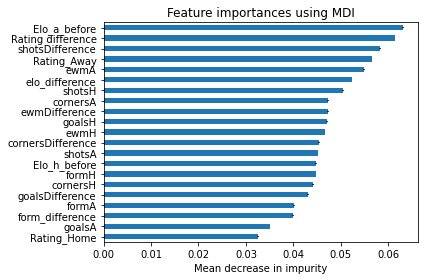

In [653]:
    #start_time = time.time()
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
#elapsed_time = time.time() - start_time


#feature_names = [f"feature {i}" for i in range(X.shape[1])]


forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values()
fig, ax = plt.subplots()

forest_importances.plot.barh(ax=ax, yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()

In [654]:
#for measuring training time
from time import time
# F1 score (also F-score or F-measure) is a measure of a test's accuracy.
#It considers both the precision p and the recall r of the test to compute
#the score: p is the number of correct positive results divided by the number of
#all positive results, and r is the number of correct positive results divided by
#the number of positive results that should have been returned. The F1 score can be
#interpreted as a weighted average of the precision and recall, where an F1 score
#reaches its best value at 1 and worst at 0.
from sklearn.metrics import f1_score


def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''

    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()

    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))


def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''

    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)

    end = time()
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))

    return f1_score(target, y_pred, average='weighted'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''

    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))

    # Train the classifier
    train_classifier(clf, X_train, y_train)

    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print(f1, acc)
    print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1, acc))

    f1, acc = predict_labels(clf, X_test, y_test)
    print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1, acc))

In [655]:
train_predict(xgb_model, X_train, y_train, X_test, y_test)
print('')
train_predict(rf_model, X_train, y_train, X_test, y_test)

Training a XGBClassifier using a training set size of 304. . .
Trained model in 0.2005 seconds
Made predictions in 0.0040 seconds.
1.0 1.0
F1 score and accuracy score for training set: 1.0000 , 1.0000.
Made predictions in 0.0030 seconds.
F1 score and accuracy score for test set: 0.4328 , 0.4737.

Training a RandomForestClassifier using a training set size of 304. . .
Trained model in 0.1470 seconds
Made predictions in 0.0120 seconds.
1.0 1.0
F1 score and accuracy score for training set: 1.0000 , 1.0000.
Made predictions in 0.0080 seconds.
F1 score and accuracy score for test set: 0.5036 , 0.5658.
